In [80]:
import pygeostat as gs
from sdcalc import *
from PoU import *
from scipy.interpolate import RBFInterpolator
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [81]:
data = gs.DataFile('data/walker.dat', x='Xlocation in meter', y='Ylocation in meter')

In [82]:
sdcalc(data, 'Xlocation in meter', 'Ylocation in meter', None, 'T variable, indicator variable')

calculating signed distances for rock type 1
calculating signed distances for rock type 2


In [83]:
data.head()

,Identification Number,Xlocation in meter,Ylocation in meter,"V variable, concentration in ppm","U variable, concentration in ppm","T variable, indicator variable",signed_distances_rt_1,signed_distances_rt_2
0,1.0,11.0,8.0,0.0,NaN,2.0,168.433963,-168.433963
1,2.0,8.0,30.0,0.0,NaN,2.0,161.743624,-161.743624
2,3.0,9.0,48.0,224.4,NaN,2.0,145.890370,-145.890370
3,4.0,8.0,69.0,434.4,NaN,2.0,129.468143,-129.468143
4,5.0,9.0,90.0,412.1,NaN,2.0,113.137085,-113.137085


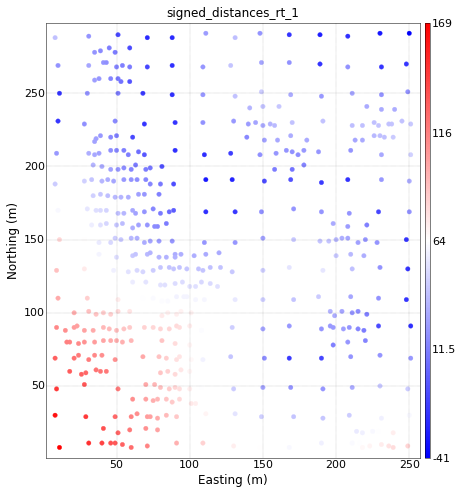

In [84]:
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr', grid=True)

In [85]:
grid = data.infergriddef(blksize=((3,3,0)))

In [86]:
grid

Pygeostat GridDef:
85 4.5 3.0 
98 4.5 3.0 
1 0.5 1.0

In [87]:
grid_coords = grid.get_coordinates()
data_coords = (data[data.x].values, data[data.y].values, np.ones(len(data))*0.5)

In [88]:
ptest = RBF_PoU(data_coords=data_coords, grid_coords=grid_coords, D=0.2, p_inf=0.05, nmax=200)

In [89]:
ptest.partition()

Number of samples in Pc: 470
Number of samples in Pl and Pu: 282
Number of samples in Pc: 282
Number of samples in Pl and Pu: 170
Number of samples in Pc: 282
Number of samples in Pl and Pu: 170
Number of samples in Pc: 170
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples less than the treshold
Number of samples in Pc: 170
Number of samples less than the treshold


In [90]:
len(ptest.used_partitions)

4

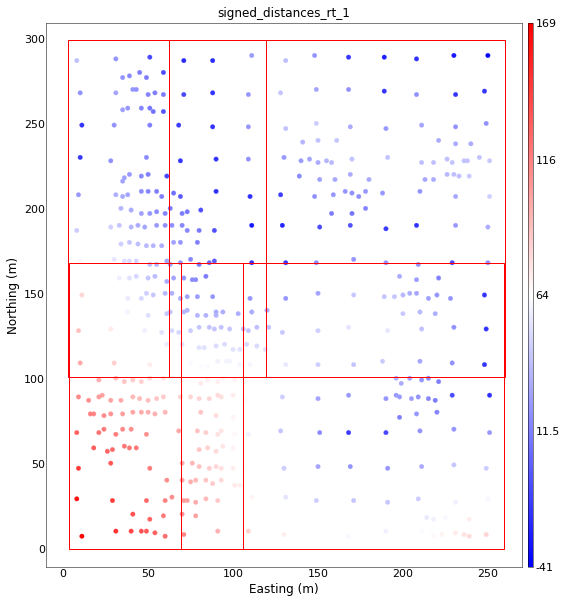

In [91]:
ups = ptest.uppers
lows = ptest.lowers

fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs, xlim=[-10,270], ylim=[-10,310])
for u, l in zip(ups, lows):

    rect1 = Rectangle((l[0], l[1]), u[0]-l[0], u[1]-l[1], linewidth=1, edgecolor='red', facecolor='none')
    axs.add_patch(rect1)

In [92]:
ptest.calculate_weights()

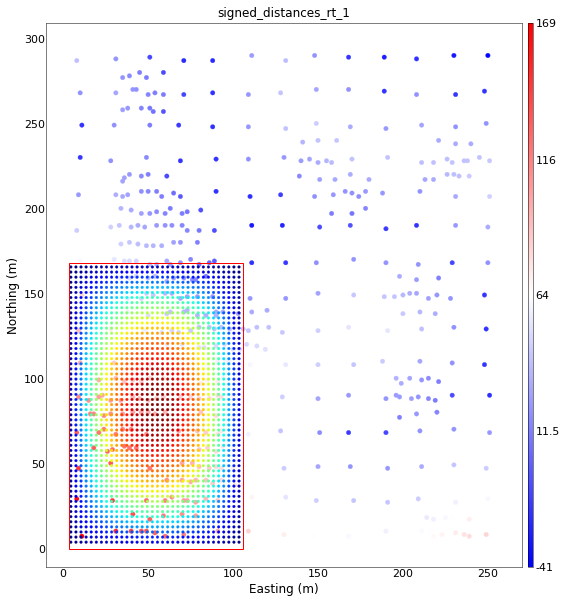

In [93]:
c=0
coords = np.array(ptest.grid_coords).T[ptest.grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs, xlim=[-10,270], ylim=[-10,310])
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.weights[c], cmap='jet')

In [94]:
ptest.normalize_weights()

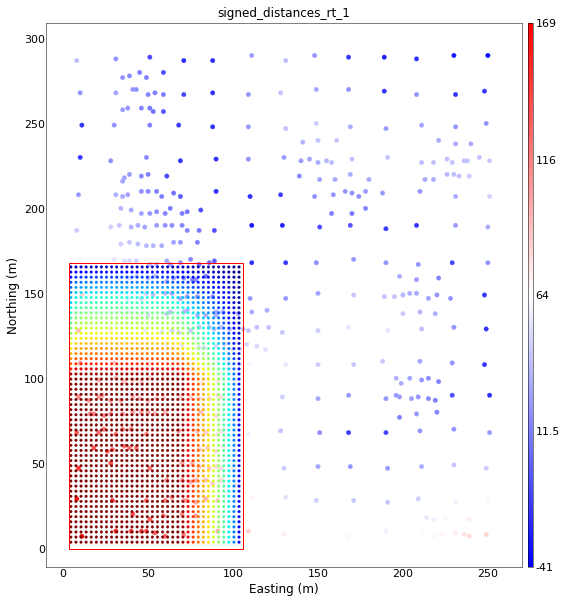

In [95]:
c=0
coords = np.array(ptest.grid_coords).T[ptest.grids_used[c]].T
x, y, z = coords[0], coords[1], coords[2]
fig, axs = plt.subplots(1,1, figsize=(10,10))
_ = gs.location_plot(data, var='signed_distances_rt_1', cmap='bwr',ax=axs, xlim=[-10,270], ylim=[-10,310])
rect1 = Rectangle((lows[c][0], lows[c][1]), ups[c][0]-lows[c][0], ups[c][1]-lows[c][1], linewidth=1, edgecolor='red', facecolor='none')
axs.add_patch(rect1)
axs.scatter(x, y, s=7, c=ptest.norm_weights[c], cmap='jet')

In [96]:
global_r_pou = np.zeros(len(ptest.grid_coords[0]))

In [97]:
for idx, p in enumerate(ptest.used_partitions):
    gidx = ptest.grids_used[idx]
    xp, yp, zp = data_coords[0][p], data_coords[1][p], data_coords[2][p]
    xobs = np.array([xp, yp]).T
    yobs = data['signed_distances_rt_1'].values[p]
    xg, yg, zg = grid_coords[0][gidx], grid_coords[1][gidx], grid_coords[2][gidx]
    xflat = np.array([xg, yg]).T
    yflat = RBFInterpolator(xobs, yobs)(xflat)
    global_r_pou[gidx] = global_r_pou[gidx] + (yflat * ptest.norm_weights[idx])

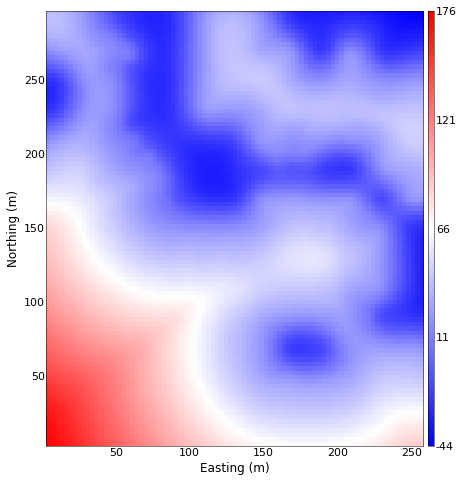

In [98]:
_ = gs.slice_plot(global_r_pou, griddef=grid, cmap='bwr')

In [99]:
xp, yp, zp = data_coords[0], data_coords[1], data_coords[2]
xobs = np.array([xp, yp]).T
yobs = data['signed_distances_rt_1'].values
xg, yg, zg = grid_coords[0], grid_coords[1], grid_coords[2]
xflat = np.array([xg, yg]).T
yflat = RBFInterpolator(xobs, yobs)(xflat)

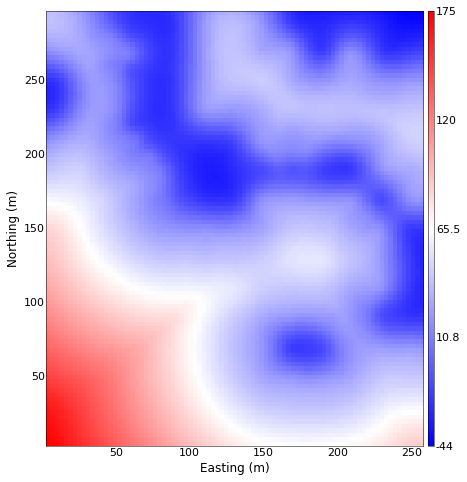

In [100]:
_ = gs.slice_plot(yflat, griddef=grid, cmap='bwr')

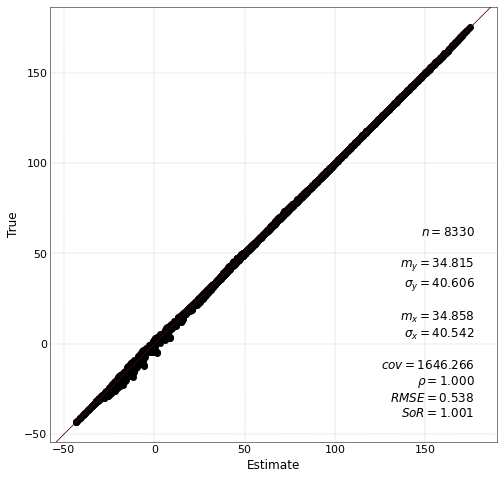

In [101]:
_ = gs.validation_plot(yflat, global_r_pou, grid=True)